Diabetes progression prediction
===============================

https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import sklearn
from sklearn.datasets import load_diabetes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LarsCV, Lars, LinearRegression

from credoai.lens import Lens
from credoai.artifacts import ClassificationModel, TabularData, RegressionModel
from credoai.evaluators import ModelFairness, Performance

In [2]:
def set_seed(seed):
    'Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.'
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

Load and process diabetes dataset
---------------------------------

In [3]:
diabetes = sklearn.datasets.load_diabetes(as_frame=True, scaled=False)

# diabetes.frame          # The dataset including target
# diabetes.data           # The dataset without target
# diabetes.target         # The target column as a pd series
# diabetes.feature_names  # A nparray with the names of the data columns

diabetes.frame

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.00,157.0,93.2,38.0,4.00,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.00,183.0,103.2,70.0,3.00,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.00,156.0,93.6,41.0,4.00,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.00,198.0,131.4,40.0,5.00,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,60.0,2.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0,178.0
438,47.0,2.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0,104.0
439,60.0,2.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0,132.0
440,36.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0,220.0


In [4]:
scaler = ColumnTransformer(
    [
        (
            'std_scaler',
            StandardScaler(),
            ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
        )
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
).set_output(transform='pandas')

scaler.fit_transform(diabetes.frame)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.800500,1.065488,1.297088,0.459841,-0.929746,-0.732065,-0.912451,-0.054499,0.418531,-0.370989,151.0
1,-0.039567,-0.938537,-1.082180,-0.553505,-0.177624,-0.402886,1.564414,-0.830301,-1.436589,-1.938479,75.0
2,1.793307,1.065488,0.934533,-0.119214,-0.958674,-0.718897,-0.680245,-0.054499,0.060156,-0.545154,141.0
3,-1.872441,-0.938537,-0.243771,-0.770650,0.256292,0.525397,-0.757647,0.721302,0.476983,-0.196823,206.0
4,0.113172,-0.938537,-0.764944,0.459841,0.082726,0.327890,0.171178,-0.054499,-0.672502,-0.980568,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.876870,1.065488,0.413360,1.256040,-0.119769,-0.053957,-0.602843,-0.054499,0.655787,0.151508,178.0
438,-0.115937,1.065488,-0.334410,-1.422086,1.037341,1.664355,-0.602843,0.721302,-0.380819,0.935254,104.0
439,0.876870,1.065488,-0.334410,0.363573,-0.785107,-0.290965,-0.525441,-0.232934,-0.985649,0.325674,132.0
440,-0.956004,-0.938537,0.821235,0.025550,0.343075,0.321306,-0.602843,0.558384,0.936163,-0.545154,220.0


Train a LarsCV regression model and compare prediction
------------------------------------------------------

In [5]:
model = Pipeline(
    [
        ('scaler', scaler),
        ('regression', LarsCV())
    ]
).set_output(transform='pandas')

model.fit(diabetes.data, diabetes.target)
model.score(diabetes.data, diabetes.target)

0.500052433693913

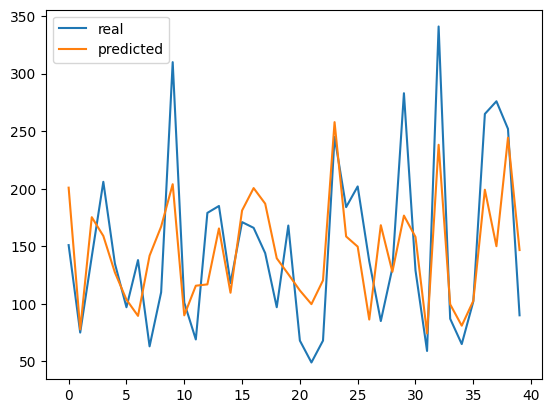

In [6]:
prediction = diabetes.frame.copy()
prediction.target = model.predict(diabetes.data)

plt.plot(diabetes.frame.head(40)['target'], label="real")
plt.plot(prediction.head(40)['target'], label="predicted")

plt.legend()

plt.show()

Insert it into a CredoAI Lens and analyze the result
----------------------------------------------------

In [7]:
# transformed_data = scale_xf.fit_transform(bias_data)
#dropped_data = dissoc_y_xf.fit_transform(bias_data)

credo_model = RegressionModel(name="diabetes-regression",
                              model_like=model)
credo_data = TabularData(
    name="diabetes-data",
    X=diabetes.data,
    y=diabetes.target,
    sensitive_features=diabetes.data.sex,
)

In [8]:
lens = Lens(model=credo_model, assessment_data=credo_data)

metrics = ["max_error", "R2_Score"]
lens.add(ModelFairness(metrics=metrics))
lens.add(Performance(metrics=metrics))
lens.run()
None

2023-04-20 15:31:23,143 - lens - INFO - Evaluator ModelFairness added to pipeline. Sensitive feature: sex
2023-04-20 15:31:23,152 - lens - INFO - Evaluator Performance added to pipeline. 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


In [9]:
fairness_results = lens.get_results(evaluator_name='ModelFairness')[0]
results = lens.get_results()

aggr = fairness_results['results'][0]
disaggr = fairness_results['results'][1]

display(aggr)
display(disaggr)

,type,value
0,max_error_parity,6.541447
1,R2_Score_parity,0.096056


,sex,type,value
0,1.0,max_error,147.731068
1,2.0,max_error,141.189621
2,1.0,R2_Score,0.45257
3,2.0,R2_Score,0.548626


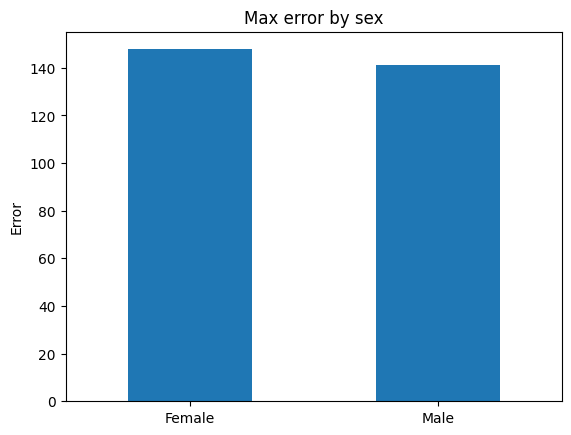

In [10]:
graph = disaggr[['sex', 'value']] \
                .head(2) \
                .rename(columns={'value': 'Score'}) \
                .replace({1: 'Female', 2: 'Male'})

plot = graph.plot.bar(ylabel='Error', legend=False, title='Max error by sex')
plot.set_xticklabels(graph.sex,
                     rotation=0)
None

Create a biased dataset and train another model with it
-------------------------------------------------------

In [11]:
def add_bias(row):
    if row.sex == 1:
        row.target = row.target * 3
    return row
    
biased_data = diabetes.frame.copy().apply(add_bias, axis=1)
biased_data


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.00,157.0,93.2,38.0,4.00,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.00,183.0,103.2,70.0,3.00,3.8918,69.0,225.0
2,72.0,2.0,30.5,93.00,156.0,93.6,41.0,4.00,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.00,198.0,131.4,40.0,5.00,4.8903,89.0,618.0
4,50.0,1.0,23.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0,405.0
...,...,...,...,...,...,...,...,...,...,...,...
437,60.0,2.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0,178.0
438,47.0,2.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0,104.0
439,60.0,2.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0,132.0
440,36.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0,660.0


In [12]:
biased_model = Pipeline(
    [
        ('scaler', scaler),
        ('regression', LarsCV())
    ]
).set_output(transform='pandas')

biased_model.fit(diabetes.data, biased_data.target)
biased_model.score(diabetes.data, biased_data.target)

0.6487353147281301

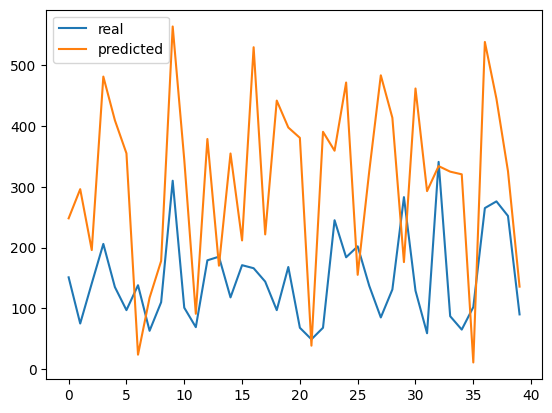

In [13]:
biased_prediction = diabetes.frame.copy()
biased_prediction.target = biased_model.predict(diabetes.data)

plt.plot(diabetes.frame.head(40)['target'], label="real")
plt.plot(biased_prediction.head(40)['target'], label="predicted")

plt.legend()

plt.show()

Insert it into a CredoAI Lens and analyze the result
----------------------------------------------------

In [14]:
# transformed_data = scale_xf.fit_transform(bias_data)
#dropped_data = dissoc_y_xf.fit_transform(bias_data)

biased_credo_model = RegressionModel(name="diabetes-regression",
                                     model_like=biased_model)
biased_credo_data = TabularData(
    name="diabetes-data",
    X=diabetes.data,
    y=biased_data.target,
    sensitive_features=diabetes.data.sex,
)

In [15]:
biased_lens = Lens(model=biased_credo_model, assessment_data=biased_credo_data)

biased_metrics = ["max_error", "R2_Score"]
biased_lens.add(ModelFairness(metrics=biased_metrics))
biased_lens.add(Performance(metrics=biased_metrics))
biased_lens.run()
None

2023-04-20 15:31:23,517 - lens - INFO - Evaluator ModelFairness added to pipeline. Sensitive feature: sex
2023-04-20 15:31:23,529 - lens - INFO - Evaluator Performance added to pipeline. 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


In [16]:
biased_fairness_results = biased_lens.get_results(evaluator_name='ModelFairness')[0]
biased_results = biased_lens.get_results()

biased_aggr = biased_fairness_results['results'][0]
biased_disaggr = biased_fairness_results['results'][1]

display(biased_disaggr)
display(biased_aggr)

,sex,type,value
0,1.0,max_error,460.27016
1,2.0,max_error,179.49011
2,1.0,R2_Score,0.413609
3,2.0,R2_Score,0.309931


,type,value
0,max_error_parity,280.780050
1,R2_Score_parity,0.103678


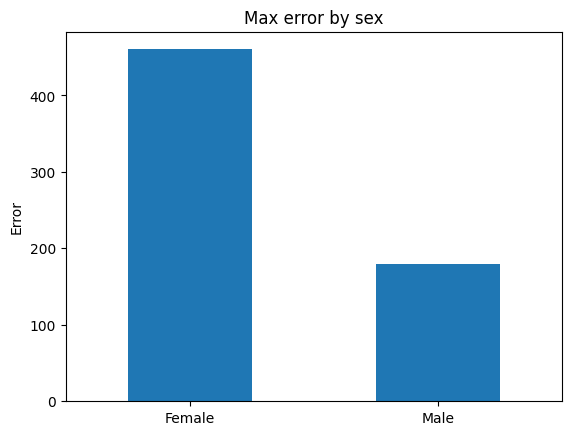

In [17]:
biased_graph = biased_disaggr[['sex', 'value']] \
                             .head(2) \
                             .rename(columns={'value': 'Score'}) \
                             .replace({1: 'Female', 2: 'Male'})

plot = biased_graph.plot.bar(ylabel='Error', legend=False, title='Max error by sex')
plot.set_xticklabels(graph.sex,
                     rotation=0)
None